# Category2.유동인구많은곳_2_군집화

## (2) 군집화

<군집화 에 사용된 라이브러리>

In [1]:
import pandas as pd
import warnings 
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, LineString, Point
warnings.filterwarnings(action='ignore')

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


전처리 파일에서 저장한 데이터 불러오기

In [2]:
data = pd.read_csv('data/category2_after_preprocessing.csv')

In [3]:
#변수들간의 상관관계
data[['인구_계','전체_추정교통량','버스_추정교통량','버스승하차','평일유동인구','주말유동인구','혼잡빈도강도','혼잡시간강도']].corr()

,인구_계,전체_추정교통량,버스_추정교통량,버스승하차,평일유동인구,주말유동인구,혼잡빈도강도,혼잡시간강도
인구_계,1.000000,-0.109126,-0.067993,-0.202295,0.013615,0.010698,-0.015201,0.037431
전체_추정교통량,-0.109126,1.000000,0.943637,0.147830,0.234678,0.234867,-0.092434,-0.188906
버스_추정교통량,-0.067993,0.943637,1.000000,0.078984,0.210287,0.217347,-0.069214,-0.163446
버스승하차,-0.202295,0.147830,0.078984,1.000000,0.269604,0.256832,0.086502,-0.002484
평일유동인구,0.013615,0.234678,0.210287,0.269604,1.000000,0.952471,-0.064602,-0.118700
주말유동인구,0.010698,0.234867,0.217347,0.256832,0.952471,1.000000,-0.073002,-0.126586
혼잡빈도강도,-0.015201,-0.092434,-0.069214,0.086502,-0.064602,-0.073002,1.000000,0.923802
혼잡시간강도,0.037431,-0.188906,-0.163446,-0.002484,-0.118700,-0.126586,0.923802,1.000000


## (2) 1. 결측값 대체

In [4]:
data.isnull().sum()

정류장ID         0
정류장명          0
동             0
lon           0
lat           0
인구_계         27
전체_추정교통량      0
승용차_추정교통량     0
버스_추정교통량      0
화물차_추정교통량     0
전체 승차 건수      9
전체 하차 건수      9
버스승하차         9
평일유동인구        0
주말유동인구        0
혼잡빈도강도       28
혼잡시간강도       28
dtype: int64

### -인구_계 결측값 대체
##### 태장동 -> 망포1.2동으로 이름 교체했기때문에, 동 이름 변경 후 망포1.2동의 인구로 NaN 대체 

In [5]:
for i in range(len(data)):
    if data['동'][i]=='태장동':
        data['동'][i] ='망포1.2동'

In [6]:
data['인구_계'] =data.apply(lambda x: 60097 if x.동=='망포1.2동' else x.인구_계,axis=1)
data['인구_계'] =data.apply(lambda x: 11263 if x.동=='지동' else x.인구_계,axis=1)
data['인구_계'].isnull().sum()

0

In [7]:
data.head()

,정류장ID,정류장명,동,lon,lat,인구_계,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,전체 승차 건수,전체 하차 건수,버스승하차,평일유동인구,주말유동인구,혼잡빈도강도,혼잡시간강도
0,201000313,권선구청,서둔동,126.970983,37.256983,38211.0,446123.0,355781.0,5243.0,85100.0,15434.0,623.0,16057.0,12430.86,2878.70,228.235556,312.944444
1,201000345,남수원초등학교,세류2동,127.016000,37.251091,23728.0,749320.0,612913.0,9680.0,126724.0,5517.0,3474.0,8991.0,14741.39,4190.02,106.830000,157.968750
2,201000379,신미주아파트,금곡동,126.953845,37.268806,45794.0,131512.0,106414.0,592.0,24507.0,3018.0,26449.0,29467.0,11751.85,5055.53,327.900000,377.447500
3,201000055,농수산물시장,권선1동,127.029815,37.256755,24895.0,495990.0,420745.0,4284.0,70964.0,42604.0,73082.0,115686.0,11958.05,3870.45,241.273333,342.006667
4,201000268,곡반중학교,곡선동,127.034254,37.246081,27497.0,1031383.0,849483.0,15600.0,166306.0,142617.0,84751.0,227368.0,33588.21,9487.21,83.941250,149.207500


### 승하차 관련 데이터 결측값 대체
####  방법: 중앙값으로 대체/ 유동인구와 가장 상관관계 높기때문에 유동인구에 비례해서 대체

In [8]:
len(data)

928

In [9]:
data.isnull().sum()

정류장ID         0
정류장명          0
동             0
lon           0
lat           0
인구_계          0
전체_추정교통량      0
승용차_추정교통량     0
버스_추정교통량      0
화물차_추정교통량     0
전체 승차 건수      9
전체 하차 건수      9
버스승하차         9
평일유동인구        0
주말유동인구        0
혼잡빈도강도       28
혼잡시간강도       28
dtype: int64

In [10]:
data[data['버스승하차'].isnull()]

,정류장ID,정류장명,동,lon,lat,인구_계,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,전체 승차 건수,전체 하차 건수,버스승하차,평일유동인구,주말유동인구,혼잡빈도강도,혼잡시간강도
17,200000293,동원고교.해우재입구,파장동,126.981611,37.315830,23573.0,300588.0,246388.0,2668.0,51528.0,NaN,NaN,NaN,3390.26,1049.26,60.362941,107.659412
671,201000417,칠보마을7단지,금곡동,126.943095,37.269382,45794.0,130310.0,105633.0,826.0,23851.0,NaN,NaN,NaN,628.88,289.44,284.433333,345.675556
708,201000418,칠보마을5단지,금곡동,126.941733,37.272319,45794.0,166191.0,132258.0,1186.0,32739.0,NaN,NaN,NaN,7277.63,3190.31,310.005000,346.537500
714,201000597,수원역환승센터(11승강장),서둔동,126.998833,37.265962,38211.0,489382.0,395385.0,4355.0,89647.0,NaN,NaN,NaN,240206.76,90920.67,64.648636,102.545455
730,201000419,칠보마을5단지,금곡동,126.941514,37.272270,45794.0,166191.0,132258.0,1186.0,32739.0,NaN,NaN,NaN,7277.63,3190.31,305.964000,343.357333
817,200000318,밤꽃사거리,율천동,126.972999,37.305283,43017.0,448137.0,358976.0,4461.0,84693.0,NaN,NaN,NaN,13548.64,4932.69,121.679565,172.671304
818,200000317,밤꽃사거리,율천동,126.972617,37.305239,43017.0,450317.0,360535.0,4469.0,85308.0,NaN,NaN,NaN,17316.59,7377.57,118.826667,170.007917
866,202000157,지동새마을금고,지동,127.020107,37.277626,11263.0,221120.0,190141.0,1666.0,29316.0,NaN,NaN,NaN,3998.34,1568.20,225.395000,243.385000
912,202000258,율천고등학교,화서2동,126.978501,37.288431,26776.0,265610.0,195404.0,2292.0,67910.0,NaN,NaN,NaN,9421.98,3918.64,139.857778,230.644444


In [11]:
from math import isnan
for i in range(len(data)):
    if isnan(data['버스승하차'][i]):
        data['버스승하차'][i] = data[(data['평일유동인구']<=(data['평일유동인구'][i]+1000))&(data['평일유동인구']>=(data['평일유동인구'][i]-1000))]['버스승하차'].median()

In [12]:
data.head()

,정류장ID,정류장명,동,lon,lat,인구_계,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,전체 승차 건수,전체 하차 건수,버스승하차,평일유동인구,주말유동인구,혼잡빈도강도,혼잡시간강도
0,201000313,권선구청,서둔동,126.970983,37.256983,38211.0,446123.0,355781.0,5243.0,85100.0,15434.0,623.0,16057.0,12430.86,2878.70,228.235556,312.944444
1,201000345,남수원초등학교,세류2동,127.016000,37.251091,23728.0,749320.0,612913.0,9680.0,126724.0,5517.0,3474.0,8991.0,14741.39,4190.02,106.830000,157.968750
2,201000379,신미주아파트,금곡동,126.953845,37.268806,45794.0,131512.0,106414.0,592.0,24507.0,3018.0,26449.0,29467.0,11751.85,5055.53,327.900000,377.447500
3,201000055,농수산물시장,권선1동,127.029815,37.256755,24895.0,495990.0,420745.0,4284.0,70964.0,42604.0,73082.0,115686.0,11958.05,3870.45,241.273333,342.006667
4,201000268,곡반중학교,곡선동,127.034254,37.246081,27497.0,1031383.0,849483.0,15600.0,166306.0,142617.0,84751.0,227368.0,33588.21,9487.21,83.941250,149.207500


In [13]:
data['버스승하차'].isnull().sum()

0

### 혼잡빈도강도, 혼잡시간강도 결측값 대체

In [14]:
data[data['혼잡빈도강도'].isnull()]

,정류장ID,정류장명,동,lon,lat,인구_계,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,전체 승차 건수,전체 하차 건수,버스승하차,평일유동인구,주말유동인구,혼잡빈도강도,혼잡시간강도
36,201000112,세류3동주민센터.버드내노인복지회관,세류3동,127.012842,37.260231,19312.0,224085.0,190133.0,2114.0,31830.0,97119.0,126181.0,223300.0,11758.65,4594.28,NaN,NaN
37,201000260,국립축산과학원,평동,126.966306,37.236135,41041.0,608.0,589.0,0.0,18.0,884.0,7738.0,8622.0,4469.31,1321.22,NaN,NaN
48,201000074,전원아파트.한라녹턴아파트,세류2동,127.015397,37.254431,23728.0,217428.0,180144.0,2574.0,34706.0,10675.0,43726.0,54401.0,38990.08,16411.81,NaN,NaN
87,200000167,연무시장입구.연무동문화센터,연무동,127.026101,37.293217,16300.0,491959.0,383497.0,6445.0,102012.0,39705.0,24837.0,64542.0,5246.70,1909.85,NaN,NaN
104,200000117,북수원시장.효자문사거리,정자1동,126.990938,37.306325,29779.0,86868.0,62711.0,492.0,23664.0,35269.0,57190.0,92459.0,11914.19,3868.61,NaN,NaN
129,202000075,경기아트센터.매탄위브하늘채,인계동,127.038914,37.262153,39288.0,391855.0,330124.0,3877.0,57851.0,39607.0,160966.0,200573.0,16708.99,5557.05,NaN,NaN
132,201000259,서둔동,서둔동,126.986174,37.270729,38211.0,268054.0,219733.0,3008.0,45310.0,85268.0,17975.0,103243.0,5685.48,1701.11,NaN,NaN
136,201000254,서둔동주민센터,서둔동,126.986650,37.270325,38211.0,115908.0,94573.0,1238.0,20095.0,31958.0,54479.0,86437.0,3837.13,1117.87,NaN,NaN
202,201000182,당수동시민농장,입북동,126.940409,37.284237,16858.0,0.0,0.0,0.0,0.0,2228.0,4590.0,6818.0,2160.51,946.52,NaN,NaN
268,200000008,문암골,연무동,127.027700,37.308946,16300.0,0.0,0.0,0.0,0.0,28287.0,13357.0,41644.0,7922.76,4550.08,NaN,NaN


In [15]:
from math import isnan
for i in range(len(data)):
    if isnan(data['혼잡빈도강도'][i]):
        data['혼잡빈도강도'][i] = data[data['동']==data['동'][i]]['혼잡빈도강도'].median()
        data['혼잡시간강도'][i] = data[data['동']==data['동'][i]]['혼잡시간강도'].median()

In [16]:
data.isnull().sum()

정류장ID        0
정류장명         0
동            0
lon          0
lat          0
인구_계         0
전체_추정교통량     0
승용차_추정교통량    0
버스_추정교통량     0
화물차_추정교통량    0
전체 승차 건수     9
전체 하차 건수     9
버스승하차        0
평일유동인구       0
주말유동인구       0
혼잡빈도강도       0
혼잡시간강도       0
dtype: int64

# 2. K-means 모델링

data파일을 복사하기

In [17]:
df = data.copy()

정류소 정보 데이터 남기기

In [18]:
busstop_info = df[['정류장ID','정류장명','동','lat','lon']]

- 모델링에 사용할 feature만 골라서 데이터프레임 만들기

In [19]:
total=df.loc[:,['전체_추정교통량','버스_추정교통량','버스승하차','평일유동인구','주말유동인구','혼잡빈도강도']]
total
labels= np.array(df['정류장ID'])

In [20]:
total

,전체_추정교통량,버스_추정교통량,버스승하차,평일유동인구,주말유동인구,혼잡빈도강도
0,446123.0,5243.0,16057.0,12430.86,2878.70,228.235556
1,749320.0,9680.0,8991.0,14741.39,4190.02,106.830000
2,131512.0,592.0,29467.0,11751.85,5055.53,327.900000
3,495990.0,4284.0,115686.0,11958.05,3870.45,241.273333
4,1031383.0,15600.0,227368.0,33588.21,9487.21,83.941250
...,...,...,...,...,...,...
923,61673.0,321.0,67433.0,6215.05,2217.34,283.400000
924,130962.0,658.0,55640.0,7356.28,2390.84,203.522000
925,172323.0,1302.0,141976.0,18654.19,7775.04,181.568333
926,558920.0,5998.0,15298.0,63708.36,26037.05,278.155385


## 2-1 데이터 표준화

In [21]:
sd = StandardScaler()
total_sd=pd.DataFrame(sd.fit_transform(total))
total_sd.index = labels

In [22]:
total_sd.head()

,0,1,2,3,4,5
201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307
201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064
201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366
201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211
201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275


## 2-2 가장 적합한 k 찾기

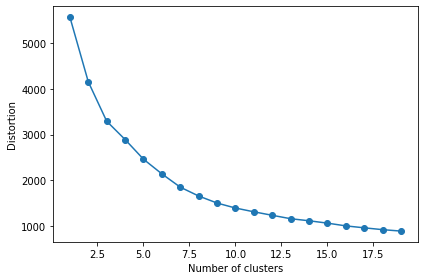

In [23]:
dist =[]
for i in range(1,20):
    k = KMeans(n_clusters=i,
          init='k-means++',
           n_init=10,
           max_iter=300,
           random_state=0)
    k.fit(total_sd)
    dist.append(k.inertia_)

plt.plot(range(1,20),dist, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

## 2-3 k-means train

In [24]:
np.random.seed(1234)

In [25]:
total_sd_arr = total_sd.values

#k값을 5로 설정 후 k-means에 적용시키기
kmeans = KMeans(n_clusters =5,random_state=2021).fit(total_sd_arr)
kmeans.cluster_centers_


array([[ 0.35348495,  0.3853127 ,  0.15999784,  3.42052849,  3.3456416 ,
        -0.49150956],
       [-0.6700003 , -0.64346921, -0.11279004, -0.27203487, -0.25399118,
         0.68095697],
       [ 1.30585516,  1.35301324,  0.10151098,  0.15864244,  0.14159185,
         0.19240985],
       [ 0.96632536,  0.54768296,  9.08347885,  1.86552665,  1.74982564,
         0.74264729],
       [-0.16059309, -0.21827237, -0.13293608, -0.28673192, -0.28389357,
        -0.85383718]])

In [26]:
total_sd['cluster'] = kmeans.labels_
total_sd

,0,1,2,3,4,5,cluster
201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307,1
201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064,2
201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366,1
201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211,1
201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275,2
...,...,...,...,...,...,...,...
202000249,-1.343254,-1.105444,-0.367138,-0.600827,-0.556324,1.098416,1
202000241,-1.056882,-1.006661,-0.397408,-0.564081,-0.541637,0.130995,1
202000246,-0.885937,-0.817888,-0.175806,-0.200302,-0.085853,-0.134891,1
202000239,0.711870,0.558626,-0.500955,1.250389,1.460067,1.034898,2


In [27]:
total_sd.iloc[:,0:6]

,0,1,2,3,4,5
201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307
201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064
201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366
201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211
201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275
...,...,...,...,...,...,...
202000249,-1.343254,-1.105444,-0.367138,-0.600827,-0.556324,1.098416
202000241,-1.056882,-1.006661,-0.397408,-0.564081,-0.541637,0.130995
202000246,-0.885937,-0.817888,-0.175806,-0.200302,-0.085853,-0.134891
202000239,0.711870,0.558626,-0.500955,1.250389,1.460067,1.034898


## 2-4 t-SNE (K-means 결과 시각화)

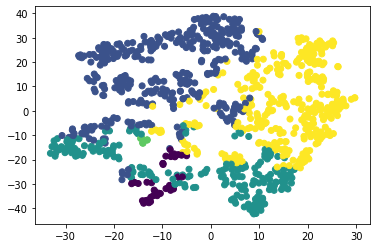

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100)
transformed = model.fit_transform(total_sd.iloc[:,:6])

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=kmeans.labels_)

plt.show()

#군집별로 잘 구분이 된 것을 알 수 있다.

## 2-5 분석 결과

### 버스정류장 정보 데이터와 군집화 결과 결합

In [29]:
total_sd.reset_index(inplace=True)

total_sd.rename(columns={'index':'정류장ID',0:'평일_전체_추정교통량',1:'평일_버스_추정교통량',2:'버스승하차',3:'평일유동인구',4:'주말유동인구',5:'평일_혼잡빈도강도'},inplace=True)

In [30]:
total_sd

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster
0,201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307,1
1,201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064,2
2,201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366,1
3,201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211,1
4,201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275,2
...,...,...,...,...,...,...,...,...
923,202000249,-1.343254,-1.105444,-0.367138,-0.600827,-0.556324,1.098416,1
924,202000241,-1.056882,-1.006661,-0.397408,-0.564081,-0.541637,0.130995,1
925,202000246,-0.885937,-0.817888,-0.175806,-0.200302,-0.085853,-0.134891,1
926,202000239,0.711870,0.558626,-0.500955,1.250389,1.460067,1.034898,2


In [31]:
total_sd['cluster'].value_counts()

1    360
4    314
2    206
0     42
3      6
Name: cluster, dtype: int64

정류장ID 기준으로 결합

In [32]:
final = pd.merge(total_sd,busstop_info,on='정류장ID',how='left')
final.head()

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon
0,201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307,1,권선구청,서둔동,37.256983,126.970983
1,201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064,2,남수원초등학교,세류2동,37.251091,127.016000
2,201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366,1,신미주아파트,금곡동,37.268806,126.953845
3,201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211,1,농수산물시장,권선1동,37.256755,127.029815
4,201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275,2,곡반중학교,곡선동,37.246081,127.034254


In [33]:
final_score = final[['평일_전체_추정교통량','평일_버스_추정교통량','버스승하차','평일유동인구','주말유동인구','평일_혼잡빈도강도','cluster']].groupby('cluster').mean()
final_score

,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도
cluster,,,,,,
0,0.353485,0.385313,0.159998,3.420528,3.345642,-0.491510
1,-0.670247,-0.643822,-0.110927,-0.272716,-0.254690,0.678253
2,1.307788,1.356081,0.103950,0.162862,0.145362,0.195482
3,0.966325,0.547683,9.083479,1.865527,1.749826,0.742647
4,-0.155285,-0.213523,-0.135989,-0.287348,-0.284306,-0.854309


In [34]:
final[final['cluster']==4].head()

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon
6,200000292,-1.132330,-0.868892,-0.502685,-0.720434,-0.655638,-1.329341,4,백선교회,파장동,37.311610,126.977691
7,202000089,0.003796,0.162321,-0.233509,-0.258024,-0.213783,-0.904830,4,화서역,화서2동,37.284140,126.990494
8,201000358,-0.459328,-0.566387,-0.246306,-0.289158,-0.301892,-1.734159,4,한양수자인파크원아파트.금호초등학교,금곡동,37.265969,126.952716
11,201000348,-1.078225,-0.982625,-0.463137,-0.726201,-0.678058,-1.056535,4,오목천공원,평동,37.243032,126.974516
12,202000090,0.267089,0.395063,-0.192654,0.254261,0.213953,-0.904830,4,화서역,화서2동,37.283895,126.990107


In [35]:
final[final['cluster']==2].head(20)

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon
1,201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064,2,남수원초등학교,세류2동,37.251091,127.016000
4,201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275,2,곡반중학교,곡선동,37.246081,127.034254
29,201000327,0.864638,0.809541,-0.530385,-0.332580,-0.345514,1.127362,2,오현초등학교,평동,37.245792,126.968264
30,203000243,1.532900,1.463503,-0.532105,0.201921,-0.282754,-0.925310,2,원천신미주아파트,원천동,37.267003,127.066236
32,201000265,0.425490,0.082591,-0.024599,1.166251,1.625286,0.286549,2,권선초등학교,권선1동,37.263807,127.023056
42,201000310,0.718644,0.877546,-0.511437,0.002265,-0.129223,0.895897,2,입북동주민센터,입북동,37.294123,126.959709
47,201000076,0.859042,1.618566,-0.489741,-0.375278,-0.370592,-0.860238,2,입북동입구,입북동,37.291617,126.960496
49,201000068,1.192485,1.335407,-0.534433,-0.270774,-0.371137,0.990546,2,평동,평동,37.259393,126.994388
51,201000018,0.632297,0.292469,0.205167,1.778377,1.461353,2.175614,2,고색역.고색초교.태산아파트,평동,37.250643,126.979691
52,201000017,1.406715,1.151032,-0.500049,0.699382,0.900469,1.116680,2,수원여자대학입구,평동,37.246711,126.965637


In [36]:
final[final['cluster']==1].head(20)

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon
0,201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307,1,권선구청,서둔동,37.256983,126.970983
2,201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366,1,신미주아파트,금곡동,37.268806,126.953845
3,201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211,1,농수산물시장,권선1동,37.256755,127.029815
5,201000337,-1.067028,-0.956830,-0.335080,-0.634683,-0.586656,0.015551,1,경기도건설본부.경기도동물위생시험소.칠보마을7단지,금곡동,37.267677,126.941563
9,201000357,-0.657960,-0.642600,-0.262387,-0.224799,-0.159349,-0.074597,1,수원은혜교회.한양수자인파크원아파트,금곡동,37.266016,126.953978
10,201000377,-0.874753,-0.968555,-0.392657,0.091411,0.136112,0.925831,1,삼익아파트,금곡동,37.269865,126.957875
14,201000353,-0.754429,-0.628530,-0.509630,-0.281467,-0.437384,-0.145940,1,들바람공원,평동,37.241142,126.977678
15,201000065,-0.801115,-0.710018,-0.537862,-0.381102,-0.450159,0.933845,1,고색삼거리,평동,37.253752,126.988651
16,201000137,-1.396726,-1.118635,0.055537,-0.236106,-0.215567,1.321142,1,우방아파트,서둔동,37.268897,126.974871
18,202000082,0.412760,0.005206,1.558782,0.865933,0.346954,1.988511,1,한국전력경기사업본부.한라시그마팰리스,인계동,37.277848,127.028695


In [37]:
final[final['cluster']==0].head()

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon
33,203000185,-0.981372,-0.921068,-0.526776,4.959137,0.364679,0.185502,0,삼성DigitalCity홍보관,매탄3동,37.258619,127.057094
43,201000312,-1.152594,-0.734055,-0.510701,1.800868,2.316755,-1.193513,0,웅비아파트,입북동,37.297656,126.958041
44,203000189,1.243040,1.457054,-0.499166,1.989017,3.253222,-1.610951,0,광교더샵주상복합,광교1동,37.271229,127.062635
45,203000188,1.583669,1.738747,-0.509915,2.200244,2.839058,-0.677046,0,광교더샵주상복합,원천동,37.270451,127.061896
123,203000152,0.849264,0.544263,0.139331,5.940521,7.205667,-1.329851,0,영통아이파크캐슬1단지.래미안영통마크원2단지,망포1.2동,37.245039,127.046286


In [38]:
final[final['cluster']==3].head()

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon
712,202000106,0.878046,0.465706,7.696090,3.166245,2.863910,0.235688,3,수원역.AK플라자,매산동,37.267365,127.000904
767,202000208,2.212320,1.255091,12.940973,0.894966,0.784393,0.732922,3,수원역.노보텔수원,매산동,37.268112,126.999608
783,202000105,0.876194,0.542211,6.542626,2.719417,3.016686,0.238530,3,수원역.AK플라자,매산동,37.264938,127.001484
843,202000219,0.848805,0.457205,14.540107,3.166245,2.863910,0.271052,3,수원역.AK플라자,매산동,37.267460,127.000934
856,202000224,0.169661,0.040675,6.947162,0.589858,0.581414,2.505742,3,매산시장,매산동,37.267314,127.003406


In [39]:
final_score

,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도
cluster,,,,,,
0,0.353485,0.385313,0.159998,3.420528,3.345642,-0.491510
1,-0.670247,-0.643822,-0.110927,-0.272716,-0.254690,0.678253
2,1.307788,1.356081,0.103950,0.162862,0.145362,0.195482
3,0.966325,0.547683,9.083479,1.865527,1.749826,0.742647
4,-0.155285,-0.213523,-0.135989,-0.287348,-0.284306,-0.854309


### 분석 결과

유동인구가 많고, 번화가인 군집 순서 정하기

-cluster4> cluster2 > cluster1 > cluster0 > cluster3

1. cluster4 : 교통량, 유동인구가 모두 많고 버스승하차도 많은 곳 / ex: 수원역 버스환승센터 등
2. cluster2 : 교통량은 적지만 버스승하차가 많고, 유동인구도 많은 곳 / ex:아주대병원 광교더샵주상복합 등
3. cluster1 : 교통량은 많지만 버스승하차와 유동인구 적은 곳 / ex:곡반중학교 남수원초등학교 등
4. cluster0 : 교통량, 버스승하차, 유동인구가 적지만 평일 혼잡빈도강도가 강한 곳/ ex:농수산물시장	화서오거리 등
5. cluster3 : 교통량, 버스승하차, 유동인구 모두 적은 곳 / ex:고등동사거리 구운동하이마트 등

cluster 3 -> 1점 

cluster 0 -> 0.8점

cluster 2 -> 0.6점

cluster 1 -> 0.4점

cluster 4 -> 0.2점

## 3-1 군집별 점수 부여

In [40]:
rank=final_score.sort_values('버스승하차').index

In [41]:
final['score'] = ''

In [42]:
for i in range(len(final)):
    if final['cluster'][i]==rank[0]:
        final['score'][i]=0.2
    elif final['cluster'][i]==rank[1]:
        final['score'][i]=0.4
    elif final['cluster'][i]==rank[2]:
        final['score'][i]=0.6
    elif final['cluster'][i]==rank[3]:
        final['score'][i]=0.8
    elif final['cluster'][i]==rank[4]:
        final['score'][i]=1


In [43]:
final.head()

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon,score
0,201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307,1,권선구청,서둔동,37.256983,126.970983,0.4
1,201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064,2,남수원초등학교,세류2동,37.251091,127.016000,0.6
2,201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366,1,신미주아파트,금곡동,37.268806,126.953845,0.4
3,201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211,1,농수산물시장,권선1동,37.256755,127.029815,0.4
4,201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275,2,곡반중학교,곡선동,37.246081,127.034254,0.6


# 3. 군집 내 2차 분류

### 방법: 같은 군집 내에서, 행정동 기준 인구밀도가 높은 곳일수록 더 높은 점수 부여

[https://stat.suwon.go.kr/stat/index.do]출처

In [44]:
people_density = pd.read_csv('data/인구면적.csv')
people_density.head()

,동,인구_계,면적
0,파장동,23573,8.62
1,율천동,43017,3.05
2,정자1동,29779,1.29
3,정자2동,30060,1.48
4,정자3동,42707,1.47


인구밀도 feature 생성

In [45]:
people_density['인구밀도']= people_density['인구_계']/people_density['면적']
people_density.max()

동          화서2동
인구_계      59913
면적        11.58
인구밀도    29052.4
dtype: object

군집화결과와 인구밀도 결합

In [46]:
final = pd.merge(final,people_density[['동','인구밀도']],how='left',on='동')
final

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon,score,인구밀도
0,201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307,1,권선구청,서둔동,37.256983,126.970983,0.4,7024.080882
1,201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064,2,남수원초등학교,세류2동,37.251091,127.016000,0.6,6627.932961
2,201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366,1,신미주아파트,금곡동,37.268806,126.953845,0.4,11169.268293
3,201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211,1,농수산물시장,권선1동,37.256755,127.029815,0.4,24169.902913
4,201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275,2,곡반중학교,곡선동,37.246081,127.034254,0.6,6165.246637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,202000249,-1.343254,-1.105444,-0.367138,-0.600827,-0.556324,1.098416,1,화서오거리,화서1동,37.278865,126.999697,0.4,28206.024096
924,202000241,-1.056882,-1.006661,-0.397408,-0.564081,-0.541637,0.130995,1,숙지공원.화서동굿모닝힐.화서다산도서관,화서2동,37.284316,126.995823,0.4,12630.188679
925,202000246,-0.885937,-0.817888,-0.175806,-0.200302,-0.085853,-0.134891,1,엘지아파트.금강아파트,화서2동,37.287994,126.981714,0.4,12630.188679
926,202000239,0.711870,0.558626,-0.500955,1.250389,1.460067,1.034898,2,꽃뫼신동아아파트,화서2동,37.286663,126.986076,0.6,12630.188679


같은 군집 내에서 인구밀도가 높을수록 더 높은 점수 부여하기

In [47]:
final['category2_score']=''

In [48]:
for i in range(len(final)):
    for k in range(5):
        rank_lis = sorted(list(set(final[final['cluster']==k]['인구밀도'])), reverse=True) #한 군집내의 모든 인구밀도 내림차순 정렬
        for j in range(len(rank_lis)): #내림차순 정렬한 리스트의 인덱스 순서대로 적은 점수를 차감
            if final['인구밀도'][i] == rank_lis[j]:
                final['category2_score'][i] = round((final['score'][i]-(j/len(rank_lis))*0.2)*10,2) # 점수 만점을 10점으로 만들기
        

In [49]:
#실행결과
final

,정류장ID,평일_전체_추정교통량,평일_버스_추정교통량,버스승하차,평일유동인구,주말유동인구,평일_혼잡빈도강도,cluster,정류장명,동,lat,lon,score,인구밀도,category2_score
0,201000313,0.245680,0.337317,-0.499007,-0.400686,-0.500339,0.430307,1,권선구청,서둔동,37.256983,126.970983,0.4,7024.080882,2.42
1,201000345,1.498794,1.637912,-0.517143,-0.326289,-0.389332,-1.040064,2,남수원초등학교,세류2동,37.251091,127.016000,0.6,6627.932961,4.26
2,201000379,-1.054609,-1.026007,-0.464587,-0.422549,-0.316065,1.637366,1,신미주아파트,금곡동,37.268806,126.953845,0.4,11169.268293,2.58
3,201000055,0.451780,0.056210,-0.243285,-0.415909,-0.416385,0.588211,1,농수산물시장,권선1동,37.256755,127.029815,0.4,24169.902913,3.79
4,201000268,2.664561,3.373212,0.043373,0.280556,0.059086,-1.317275,2,곡반중학교,곡선동,37.246081,127.034254,0.6,6165.246637,4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,202000249,-1.343254,-1.105444,-0.367138,-0.600827,-0.556324,1.098416,1,화서오거리,화서1동,37.278865,126.999697,0.4,28206.024096,3.89
924,202000241,-1.056882,-1.006661,-0.397408,-0.564081,-0.541637,0.130995,1,숙지공원.화서동굿모닝힐.화서다산도서관,화서2동,37.284316,126.995823,0.4,12630.188679,2.79
925,202000246,-0.885937,-0.817888,-0.175806,-0.200302,-0.085853,-0.134891,1,엘지아파트.금강아파트,화서2동,37.287994,126.981714,0.4,12630.188679,2.79
926,202000239,0.711870,0.558626,-0.500955,1.250389,1.460067,1.034898,2,꽃뫼신동아아파트,화서2동,37.286663,126.986076,0.6,12630.188679,4.79


필요한 변수만 저장

In [50]:
category2 = final[['정류장ID','정류장명','동','lat','lon','category2_score']]
category2

,정류장ID,정류장명,동,lat,lon,category2_score
0,201000313,권선구청,서둔동,37.256983,126.970983,2.42
1,201000345,남수원초등학교,세류2동,37.251091,127.016000,4.26
2,201000379,신미주아파트,금곡동,37.268806,126.953845,2.58
3,201000055,농수산물시장,권선1동,37.256755,127.029815,3.79
4,201000268,곡반중학교,곡선동,37.246081,127.034254,4.21
...,...,...,...,...,...,...
923,202000249,화서오거리,화서1동,37.278865,126.999697,3.89
924,202000241,숙지공원.화서동굿모닝힐.화서다산도서관,화서2동,37.284316,126.995823,2.79
925,202000246,엘지아파트.금강아파트,화서2동,37.287994,126.981714,2.79
926,202000239,꽃뫼신동아아파트,화서2동,37.286663,126.986076,4.79


In [51]:
category2.sort_values(by=["category2_score"], ascending=[False]).head(30)

,정류장ID,정류장명,동,lat,lon,category2_score
843,202000219,수원역.AK플라자,매산동,37.267460,127.000934,10
712,202000106,수원역.AK플라자,매산동,37.267365,127.000904,10
870,202000225,수원역.역전시장,매산동,37.265116,127.001845,10
856,202000224,매산시장,매산동,37.267314,127.003406,10
767,202000208,수원역.노보텔수원,매산동,37.268112,126.999608,10
783,202000105,수원역.AK플라자,매산동,37.264938,127.001484,10
801,202000120,수원역.헌혈의집,매산동,37.266401,127.001585,8
198,201000197,수원버스터미널,권선2동,37.249796,127.019716,7.84
123,203000152,영통아이파크캐슬1단지.래미안영통마크원2단지,망포1.2동,37.245039,127.046286,7.74
587,203000153,래미안영통마크원2단지.영통아이파크캐슬1단지,망포1.2동,37.245427,127.045991,7.74


결과 저장하기

In [52]:
category2.to_csv('data/category2.csv',index=False)

In [53]:
category2_with_cluster = final[['정류장ID','정류장명','동','lat','lon','category2_score','cluster']]
category2_with_cluster

,정류장ID,정류장명,동,lat,lon,category2_score,cluster
0,201000313,권선구청,서둔동,37.256983,126.970983,2.42,1
1,201000345,남수원초등학교,세류2동,37.251091,127.016000,4.26,2
2,201000379,신미주아파트,금곡동,37.268806,126.953845,2.58,1
3,201000055,농수산물시장,권선1동,37.256755,127.029815,3.79,1
4,201000268,곡반중학교,곡선동,37.246081,127.034254,4.21,2
...,...,...,...,...,...,...,...
923,202000249,화서오거리,화서1동,37.278865,126.999697,3.89,1
924,202000241,숙지공원.화서동굿모닝힐.화서다산도서관,화서2동,37.284316,126.995823,2.79,1
925,202000246,엘지아파트.금강아파트,화서2동,37.287994,126.981714,2.79,1
926,202000239,꽃뫼신동아아파트,화서2동,37.286663,126.986076,4.79,2


군집과 점수가 같이나와있는 데이터 저장

In [54]:
category2_with_cluster.to_csv('data/category2_wiith_cluster.csv',index=False)